In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Let's pull in the champions stats saved from the API

In [34]:
champ_stats = pd.read_csv('champ_stats.csv', index_col=0)

In [35]:
champ_stats.columns

Index(['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor',
       'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange',
       'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit',
       'critperlevel', 'attackdamage', 'attackdamageperlevel',
       'attackspeedperlevel', 'attackspeed', 'tags', 'partype'],
      dtype='object')

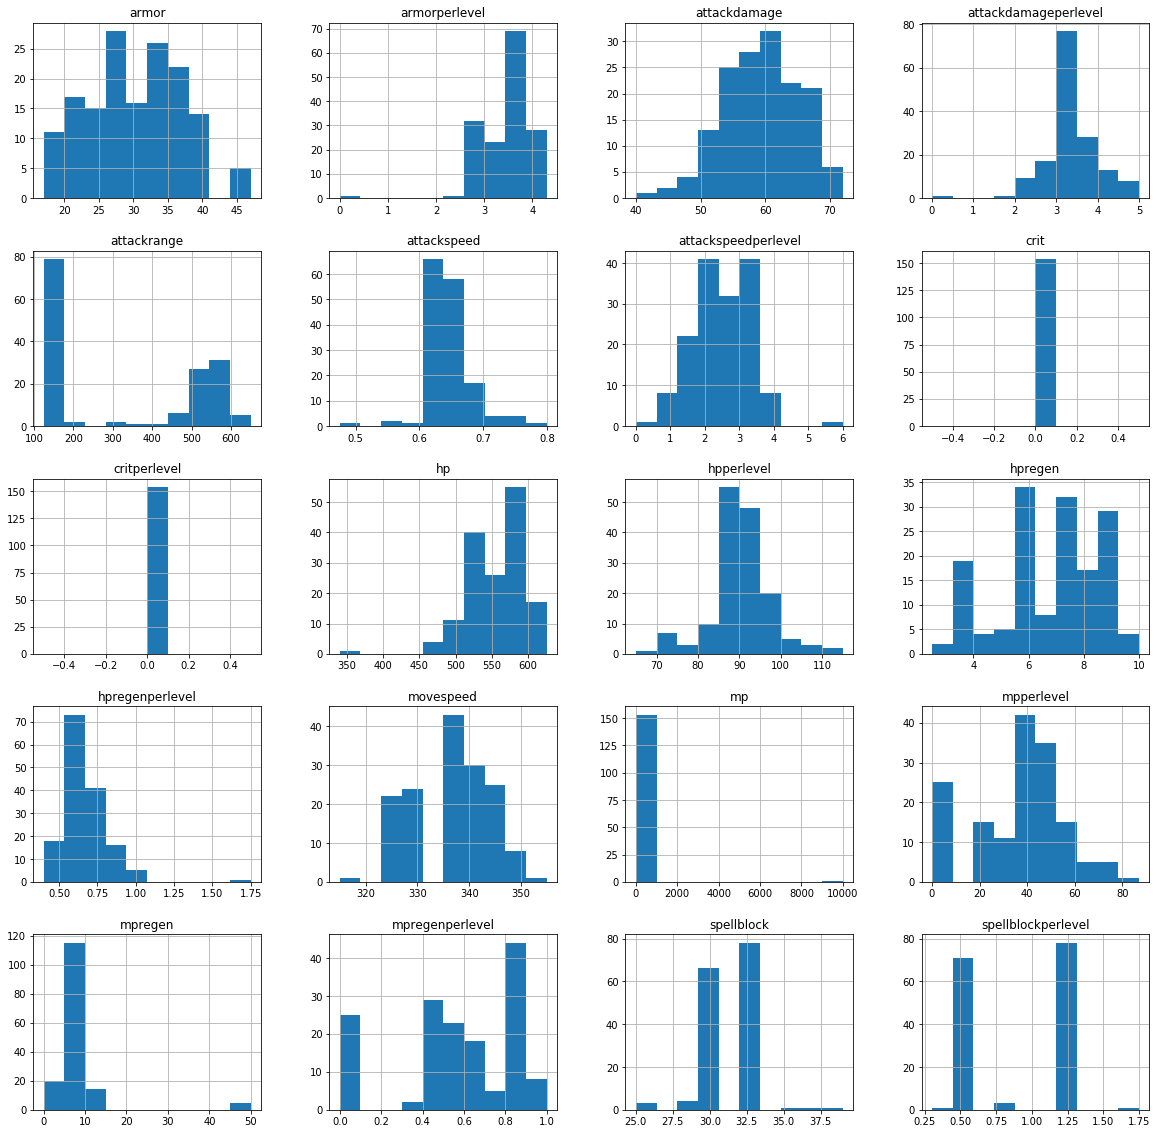

In [36]:
champ_stats.hist(figsize=(20,20))
plt.savefig('histogram', bbox_inches = 'tight')
plt.show()

There seems to be a good spread for most of the base stats. As we will see throughout our analysis, there are some general rules in League, but there is always an exception to the rule so we will see outliers one each plot.

After seeing a near normal distribution on several of the base stats and their corresponding scaler (ie armor and armorperlevel), my expectation is that those champions with high base values would also scale the best. To put another way, if a champion has high armor at level 1, they would likely have high armor at level 18 (the maximum level in the game). 

- show plots of this not being the case for any of them in a similar style summary
- look at the level 1 and the level 18 plots for each stat and where the classes land.
- do a classifier to help understand  the classes

In [37]:
champ_stats['tags'] = champ_stats['tags'].str.replace("'", '') #remove the single quotes from the column
new = champ_stats['tags'].str.lstrip('[+-]').str.rstrip(']').str.split(', ', expand=True) #make a new with the split tags so that we get both classes

# making separate first class column from new data frame
champ_stats['Primary Class']= new[0]
# making separate second class column from new data frame
champ_stats['Secondary Class']= new[1]
champ_stats.drop(columns=['tags'], inplace=True) #dropping the old column
champ_stats

,hp,hpperlevel,mp,mpperlevel,movespeed,armor,armorperlevel,spellblock,spellblockperlevel,attackrange,...,mpregenperlevel,crit,critperlevel,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed,partype,Primary Class,Secondary Class
Orianna,530.0,91.0,418.00,25.0,325.0,17.0,3.00,26.0,0.50,525.0,...,0.80,0.0,0.0,40.0,2.60,3.50,0.658,Mana,Mage,Support
Janna,500.0,70.0,350.00,64.0,315.0,28.0,3.80,30.0,0.50,550.0,...,0.40,0.0,0.0,46.0,1.50,2.95,0.625,Mana,Support,Mage
Karthus,550.0,87.0,467.00,30.5,335.0,18.0,3.50,30.0,0.50,450.0,...,0.80,0.0,0.0,46.0,3.25,2.11,0.625,Mana,Mage,None
Lulu,525.0,74.0,350.00,55.0,330.0,29.0,3.70,30.0,0.50,550.0,...,0.60,0.0,0.0,47.0,2.60,2.25,0.625,Mana,Support,Mage
Neeko,540.0,90.0,450.00,30.0,340.0,21.0,4.00,30.0,0.50,550.0,...,0.70,0.0,0.0,48.0,2.50,3.50,0.625,Mana,Mage,Support
Kennen,541.0,84.0,200.00,0.0,335.0,29.0,3.75,30.0,0.50,550.0,...,0.00,0.0,0.0,48.0,3.75,3.40,0.625,Energy,Mage,Marksman
Sona,480.0,77.0,340.00,45.0,325.0,28.0,3.30,30.0,0.50,550.0,...,0.40,0.0,0.0,49.0,3.00,2.30,0.644,Mana,Support,Mage
Soraka,535.0,74.0,425.00,40.0,325.0,32.0,3.80,30.0,0.50,550.0,...,0.40,0.0,0.0,50.0,3.00,2.14,0.625,Mana,Support,Mage
Senna,520.0,75.0,350.00,45.0,330.0,28.0,3.50,30.0,0.50,600.0,...,0.40,0.0,0.0,50.0,0.00,4.00,0.625,Mana,Marksman,Support
Ivern,585.0,85.0,450.00,60.0,330.0,27.0,3.50,32.0,1.25,475.0,...,0.75,0.0,0.0,50.0,3.00,3.40,0.644,Mana,Support,Mage


In [38]:
# champ_list = ['Aatrox', 'Darius', 'Malphite', 'Riven', 'Tristana', 'Warwick']
print(champ_stats['Primary Class'].unique())
print(champ_stats['Secondary Class'].count())

['Mage' 'Support' 'Marksman' 'Fighter' 'Tank' 'Assassin']
116


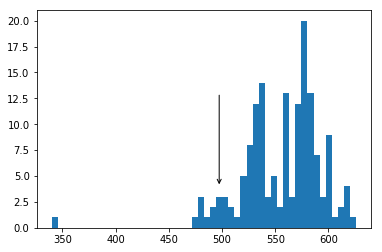

In [6]:
nbins = 50
labeled_bin = 500

fig, ax = plt.subplots()

# series = pd.Series(np.random.normal(0, 100, 1000))

## plot the histogram and return the bin position and values
ybins, xbins, _ = ax.hist(champ_stats['hp'], bins=nbins)

## find out in which bin belongs the position where you want the label
ind_bin = np.where(xbins >= labeled_bin)[0]
if len(ind_bin) > 0 and ind_bin[0] > 0:
    ## get position and value of the bin
    x_bin = xbins[ind_bin[0]-1]/2. + xbins[ind_bin[0]]/2.
    y_bin = ybins[ind_bin[0]-1]
    ## add the arrow
    ax.annotate("",
                xy=(x_bin, y_bin + 1), xycoords='data',
                xytext=(x_bin, y_bin + 10), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"),
                                )
else:
    print('Labeled bin is outside range')

In [7]:
stats = ['armor', 'attackdamage', 'attackspeed', 'crit', 'hp', 'hpregen', 'mp', 'mpregen', 'spellblock']

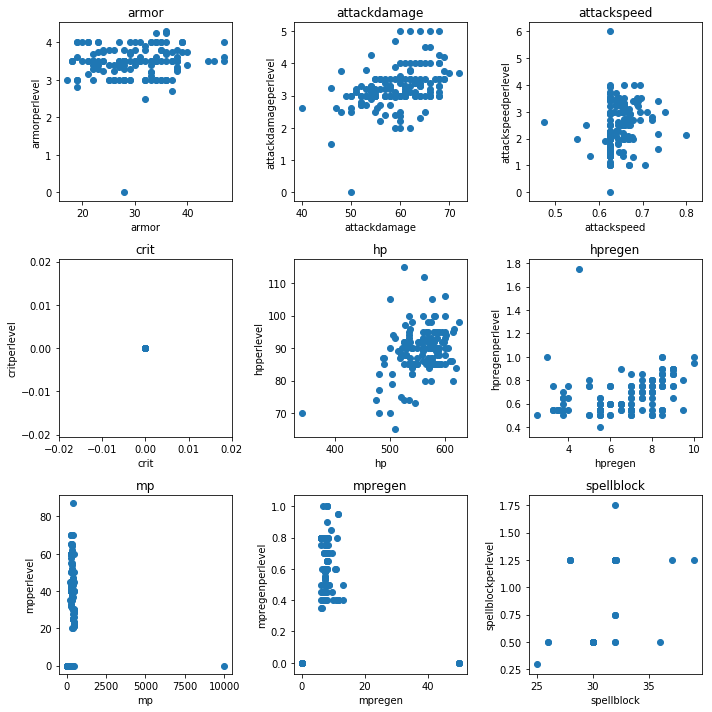

In [8]:
fig = plt.figure(figsize=(10, 10))

for stat,num in zip(stats, range(1,10)):
    ax = fig.add_subplot(3,3,num)
#     ax.plot(df0['Date'], df0[['y1','y2']])
    ax.scatter(champ_stats[stat], champ_stats[str(stat) + 'perlevel'])
    ax.set_ylabel(str(stat) + 'perlevel')
    ax.set_xlabel(str(stat))
    ax.set_title(stat)

plt.tight_layout()
plt.show()

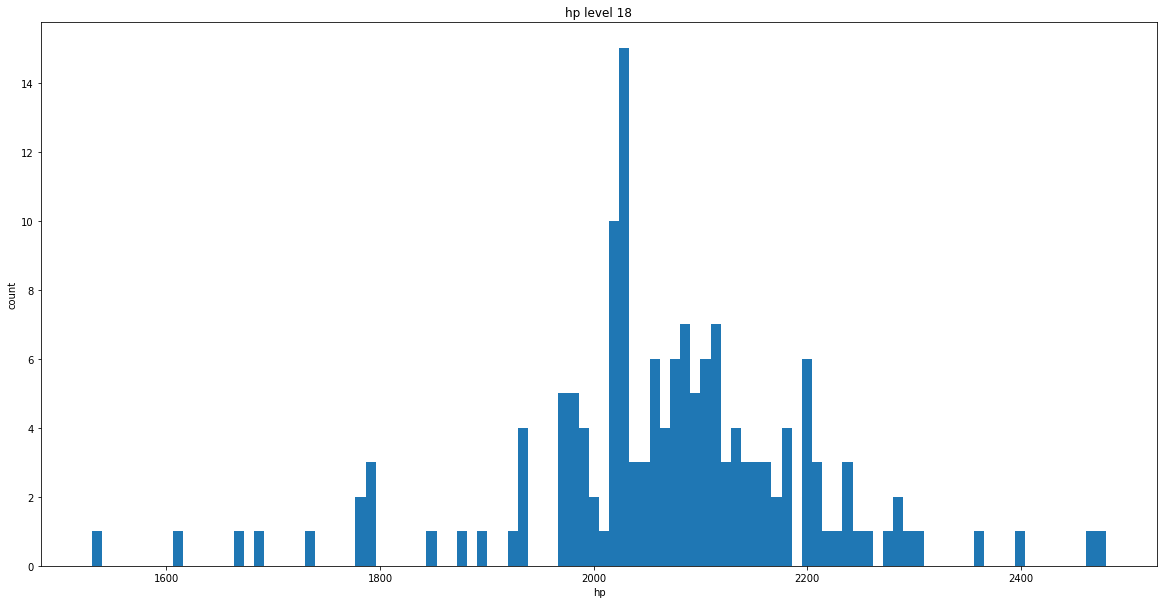

In [9]:
fig = plt.figure(figsize=(20, 10))
# plt.plot(champ_stats['Distance'][df['Activity Type']=='Run'].resample('M').sum())
plt.hist(champ_stats['hp']+(champ_stats['hpperlevel']*17), bins=100)
plt.title('hp level 18')
plt.ylabel('count')
plt.xlabel('hp')
plt.show()

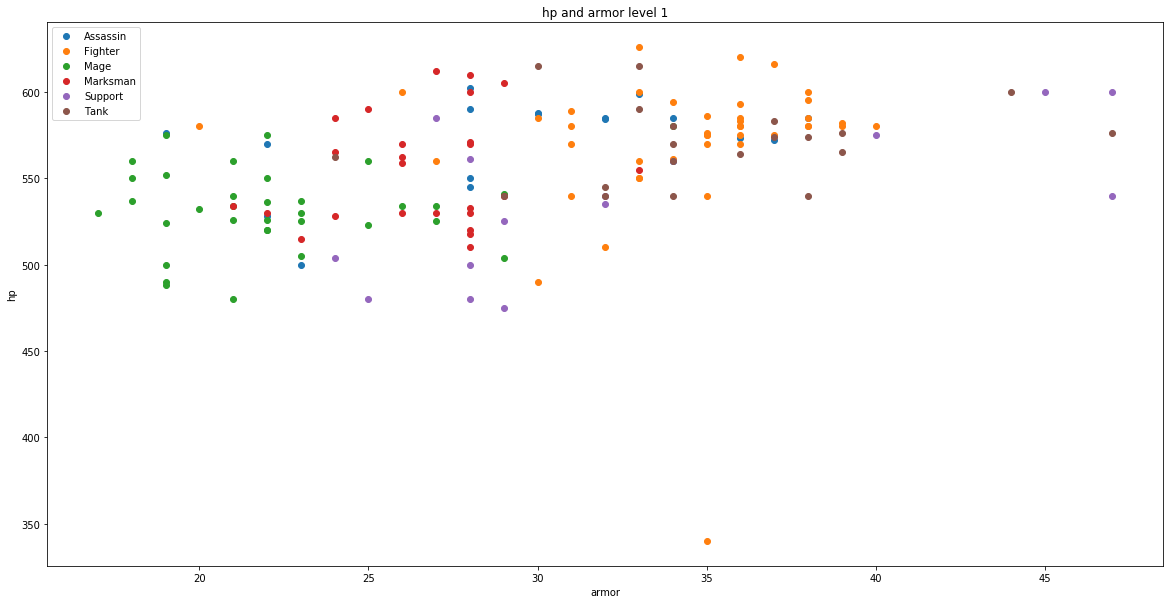

In [28]:
fig = plt.figure(figsize=(20, 10))
# plt.scatter(champ_stats['armor']+(champ_stats['armorperlevel']*17), champ_stats['hp']+(champ_stats['hpperlevel']*17))
groups = champ_stats.groupby('Primary Class')
for name, group in groups:
    plt.plot(group['armor'], group['hp'], marker="o", linestyle="", label=name)
plt.legend()
plt.title('hp and armor level 1')
plt.ylabel('hp')
plt.xlabel('armor')
plt.savefig('hp and armour lvl 1', bbox_inches = 'tight')
plt.show()

In [11]:
# for encircling if that is desired
from scipy.spatial import ConvexHull
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)
    
def encircle2(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    mean = np.mean(p, axis=0)
    d = p-mean
    r = np.max(np.sqrt(d[:,0]**2+d[:,1]**2 ))
    circ = plt.Circle(mean, radius=1.05*r,**kw)
    ax.add_patch(circ)

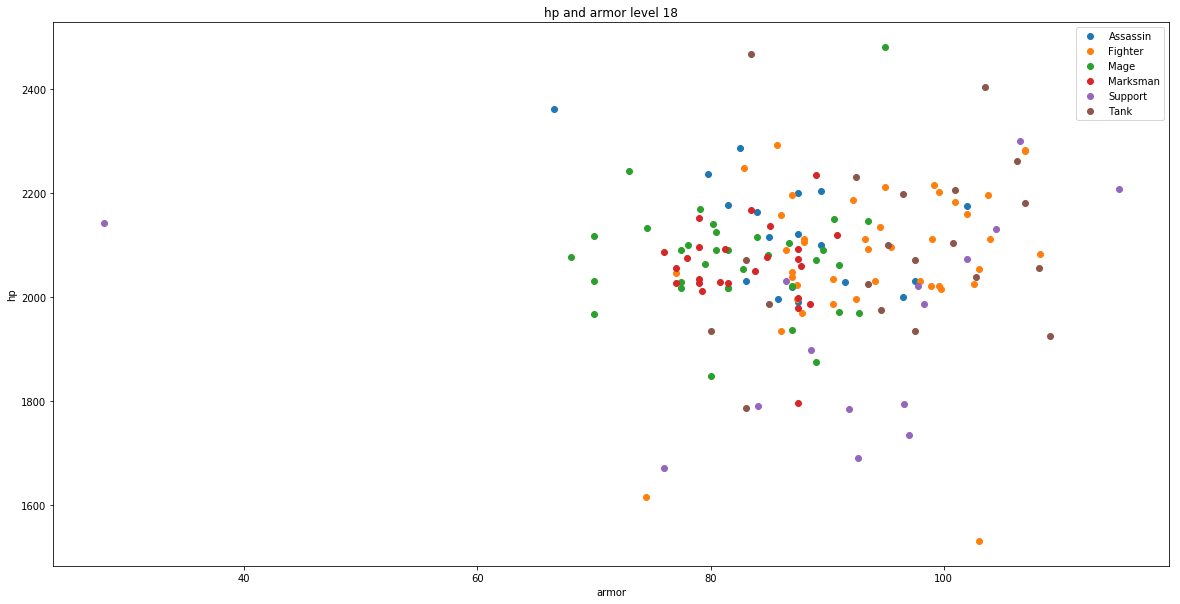

In [27]:
fig = plt.figure(figsize=(20, 10))
# plt.scatter(champ_stats['armor']+(champ_stats['armorperlevel']*17), champ_stats['hp']+(champ_stats['hpperlevel']*17))
groups = champ_stats.groupby('Primary Class')
for name, group in groups:
    plt.plot(group['armor']+(group['armorperlevel']*17), group['hp']+(group['hpperlevel']*17), marker="o", linestyle="", label=name)
plt.legend()
plt.title('hp and armor level 18')
plt.ylabel('hp')
plt.xlabel('armor')
plt.savefig('hp and armour lvl 18', bbox_inches = 'tight')
plt.show()

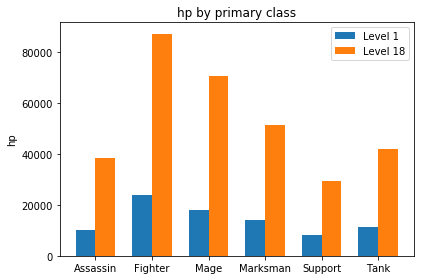

In [83]:
lvl1_hpsum = groups['hp'].sum()
lvl18_hpsum = groups['hp'].sum()+groups['hpperlevel'].sum()*17
labels = groups['hp'].sum().index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lvl1_hpsum, width, label='Level 1')
rects2 = ax.bar(x + width/2, lvl18_hpsum, width, label='Level 18')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('hp')
ax.set_title('hp by primary class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

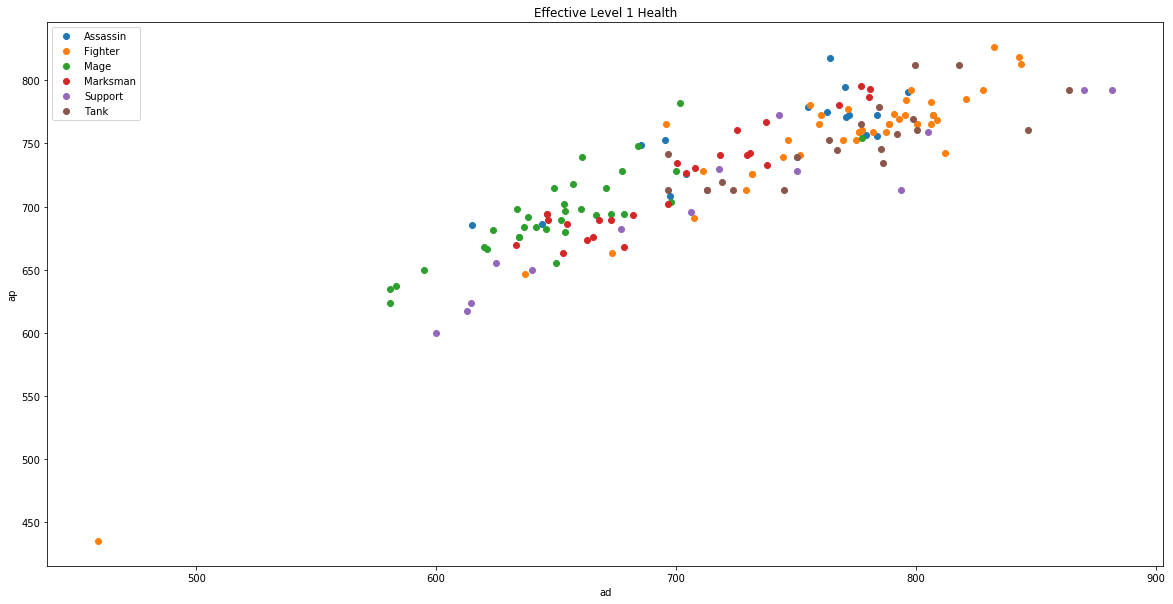

In [71]:
# need to do effective ad hp and ap 

champ_stats['Effective AD HP'] =  champ_stats['hp']*(1 + 0.01 * champ_stats['armor'])
champ_stats['Effective AP HP'] =  champ_stats['hp']*(1 + 0.01 * champ_stats['spellblock'])
fig = plt.figure(figsize=(20, 10))
# plt.scatter(ad_eff_hp, ap_eff_hp)
groups = champ_stats.groupby('Primary Class')
    
for name, group in groups:
    plt.plot(group['Effective AD HP'], group['Effective AP HP'], marker="o", linestyle="", label=name)
#     encircle(group['Effective AD HP'], group['Effective AP HP'], alpha=0.2))
    
plt.title('Effective Level 1 Health')
plt.ylabel('ap')
plt.xlabel('ad')
plt.legend()
plt.savefig('Effective Level 1 Health', bbox_inches = 'tight')
plt.show()

In [100]:
for prim_class in champ_stats['Primary Class'].unique():
    print(prim_class)
    print(champ_stats['Effective AD HP'][champ_stats['Primary Class']==prim_class].mean())
    print(champ_stats['Effective AP HP'][champ_stats['Primary Class']==prim_class].mean())

Mage
650.9831176470589
693.515294117647
Support
716.706
701.52
Marksman
702.3908
720.94
Fighter
766.0280952380953
751.045142857143
Tank
771.4495000000001
751.8729999999999
Assassin
741.0627777777778
755.6684444444445


In [101]:
lvl1_effadhp


Primary Class
Tank        771.449500
Fighter     766.028095
Assassin    741.062778
Support     716.706000
Marksman    702.390800
Mage        650.983118
Name: Effective AD HP, dtype: float64

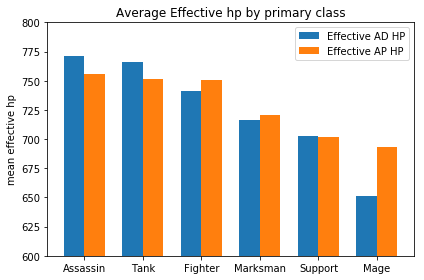

In [90]:
lvl1_effadhp = groups['Effective AD HP'].mean().sort_values(ascending=False)
lvl1_effaphp = groups['Effective AP HP'].mean().sort_values(ascending=False)
labels = groups['Effective AP HP'].mean().sort_values(ascending=False).index

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lvl1_effadhp, width, label='Effective AD HP')
rects2 = ax.bar(x + width/2, lvl1_effaphp, width, label='Effective AP HP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mean effective hp')
ax.set_title('Average Effective hp by primary class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(600,800)

fig.tight_layout()

plt.show()

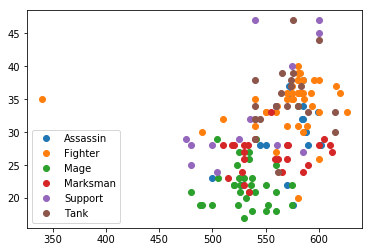

In [75]:
groups = champ_stats.groupby('Primary Class')
for name, group in groups:
    plt.plot(group['hp'], group['armor'], marker="o", linestyle="", label=name)
plt.legend()

In [15]:
champ_stats.columns

Index(['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor',
       'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange',
       'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit',
       'critperlevel', 'attackdamage', 'attackdamageperlevel',
       'attackspeedperlevel', 'attackspeed', 'partype', 'Primary Class',
       'Secondary', 'Effective AD HP', 'Effective AP HP'],
      dtype='object')

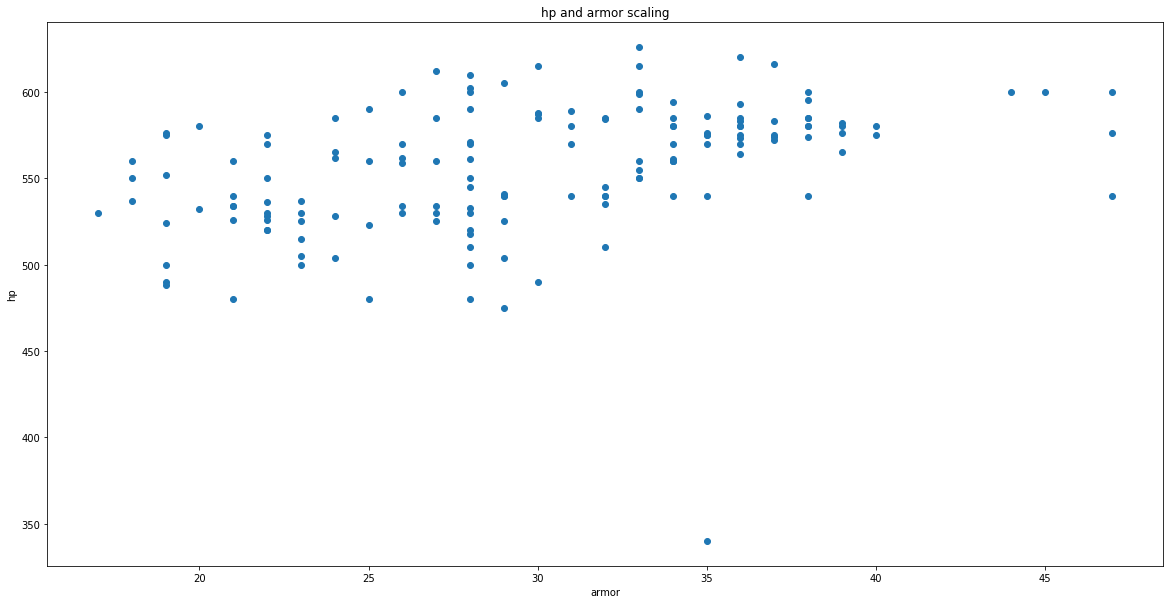

In [16]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(champ_stats['armor'], champ_stats['hp'])
plt.title('hp and armor scaling')
plt.ylabel('hp')
plt.xlabel('armor')
plt.show()

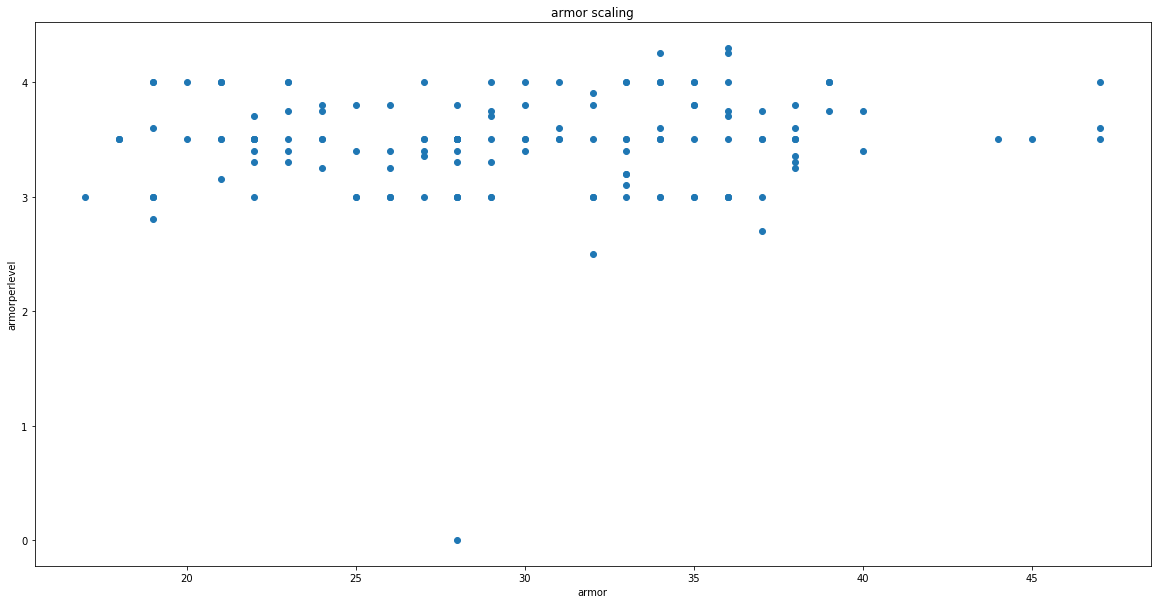

In [17]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(champ_stats['armor'], champ_stats['armorperlevel'])
plt.title('armor scaling')
plt.ylabel('armorperlevel')
plt.xlabel('armor')
plt.show()

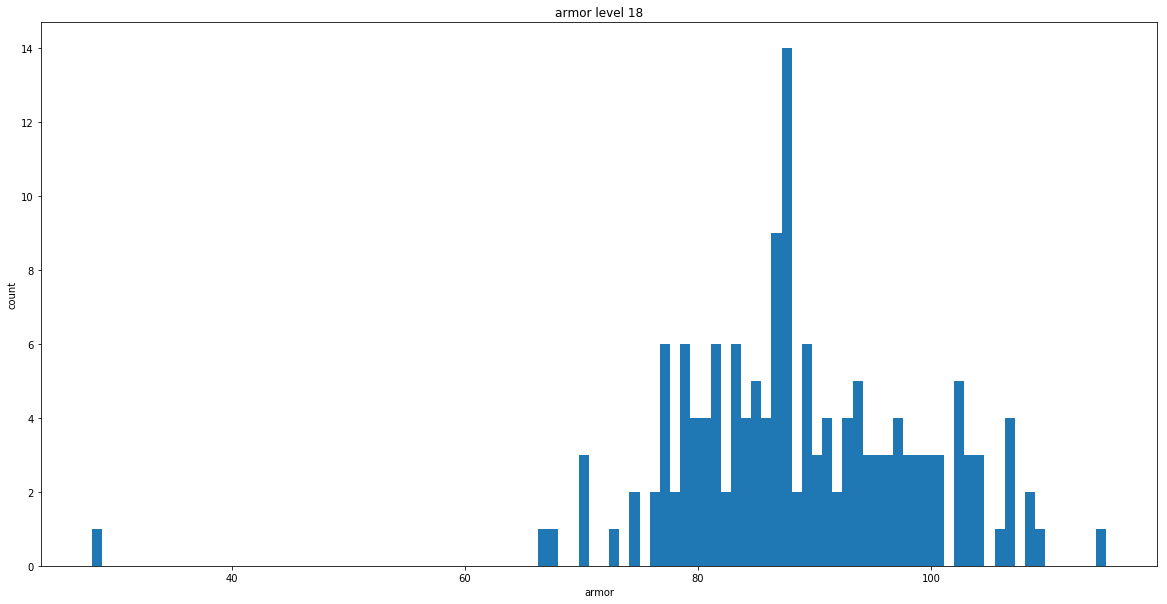

In [18]:
fig = plt.figure(figsize=(20, 10))
# plt.plot(champ_stats['Distance'][df['Activity Type']=='Run'].resample('M').sum())
plt.hist(champ_stats['armor']+(champ_stats['armorperlevel']*17), bins=100)
plt.title('armor level 18')
plt.ylabel('count')
plt.xlabel('armor')
plt.show()

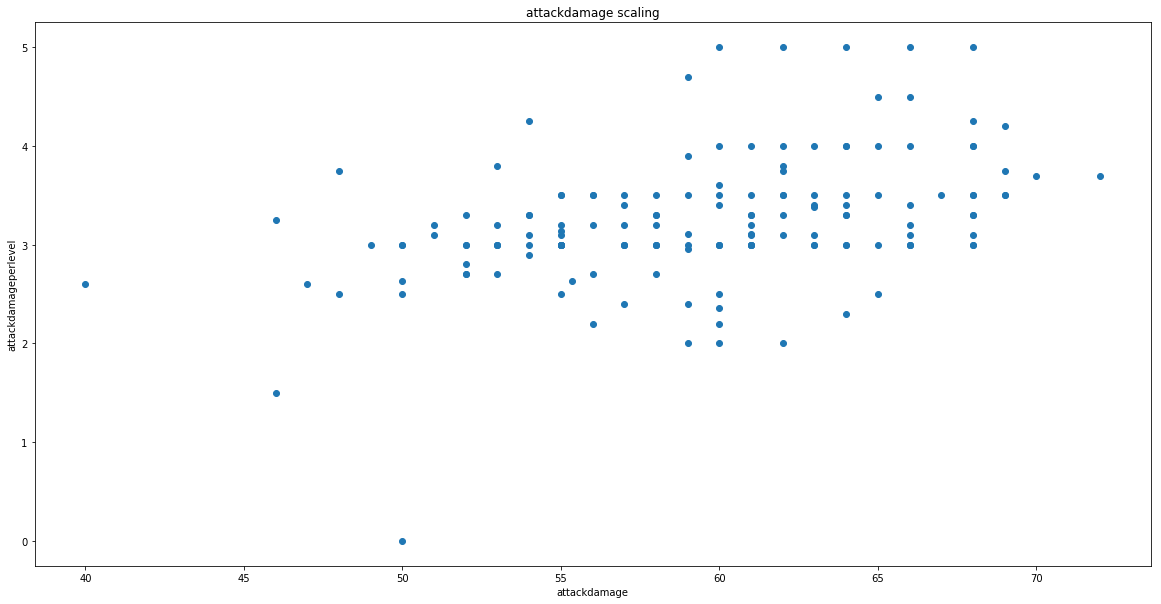

In [19]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(champ_stats['attackdamage'], champ_stats['attackdamageperlevel'])
plt.title('attackdamage scaling')
plt.ylabel('attackdamageperlevel')
plt.xlabel('attackdamage')
plt.show()

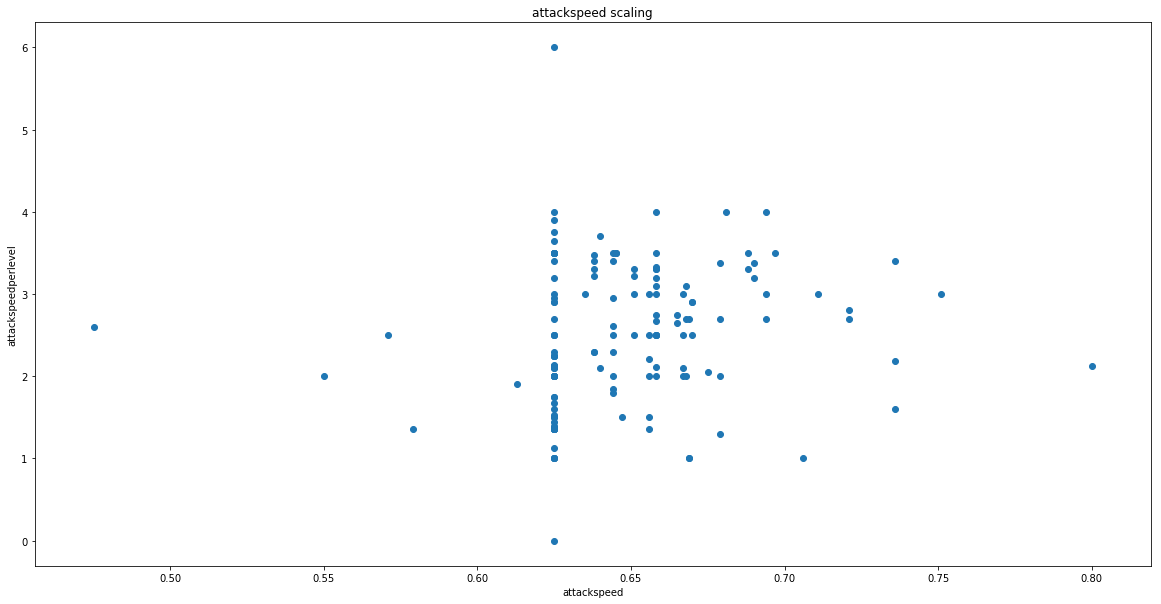

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(champ_stats['attackspeed'], champ_stats['attackspeedperlevel'])
plt.title('attackspeed scaling')
plt.ylabel('attackspeedperlevel')
plt.xlabel('attackspeed')
plt.show()

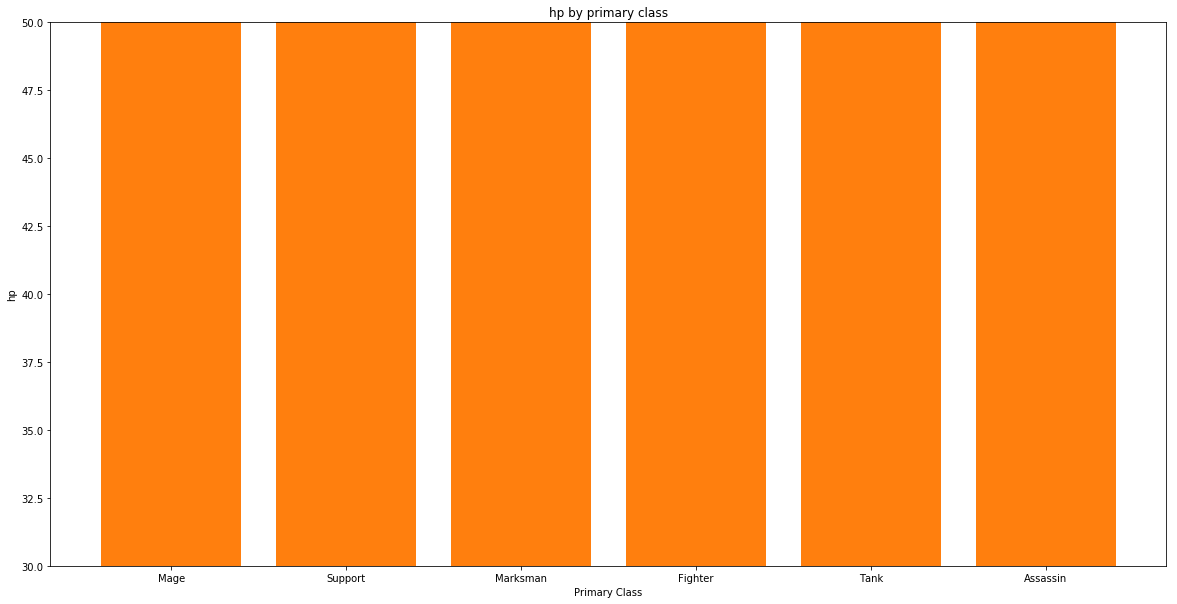

In [114]:
fig = plt.figure(figsize=(20, 10))
# plt.scatter(champ_stats['armor']+(champ_stats['armorperlevel']*17), champ_stats['hp']+(champ_stats['hpperlevel']*17))
plt.bar(champ_stats['Primary Class'], champ_stats['armor'])
plt.title('hp by primary class')
plt.ylim(30, 50)
plt.ylabel('hp')
plt.xlabel('Primary Class')
plt.show()

In [ ]:
features_sorted = []
importance_sorted = []

sorted_list = sorted(unsorted_list)

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

plt.title("Feature importance", fontsize=15)
plt.xlabel("Importance", fontsize=13)

plt.barh(range(len(importance_sorted)), importance_sorted, color="green", edgecolor='green')
plt.yticks(range(len(importance_sorted)), features_sorted);

# PCA

In [21]:
# preprocessing, pca, tsne, and kmeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [22]:
champ_stats.columns

Index(['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor',
       'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange',
       'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit',
       'critperlevel', 'attackdamage', 'attackdamageperlevel',
       'attackspeedperlevel', 'attackspeed', 'partype', 'Primary Class',
       'Secondary', 'Effective AD HP', 'Effective AP HP'],
      dtype='object')

In [23]:
features = ['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor',
       'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange',
       'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'crit',
       'critperlevel', 'attackdamage', 'attackdamageperlevel',
       'attackspeedperlevel', 'attackspeed']
x = champ_stats.loc[:, features]
# add in one hot encoded partype
partype_df = pd.get_dummies(champ_stats['partype'])
x = pd.concat([x, partype_df], axis=1)
y = champ_stats.index

In [24]:

# standardizing the features
x_minmax = MinMaxScaler().fit_transform(x)

# pca projection into 2D
pca = PCA(n_components = 2)
principal_components_minmax = pca.fit_transform(x_minmax)

# explained variance ratio
print(pca.explained_variance_ratio_)

[0.36954855 0.2079252 ]


In [25]:
pca.components_.shape

(2, 33)

In [26]:

# inputting into df for plotting
principal_df = pd.DataFrame(data = principal_components_minmax, 
                           columns = ['principal component 1', 'principal component 2'])

# recombining champion names and components
final_df = pd.concat([principal_df,pd.DataFrame(y)], axis = 1)
final_df.rename(columns={0: 'name'},inplace=True)

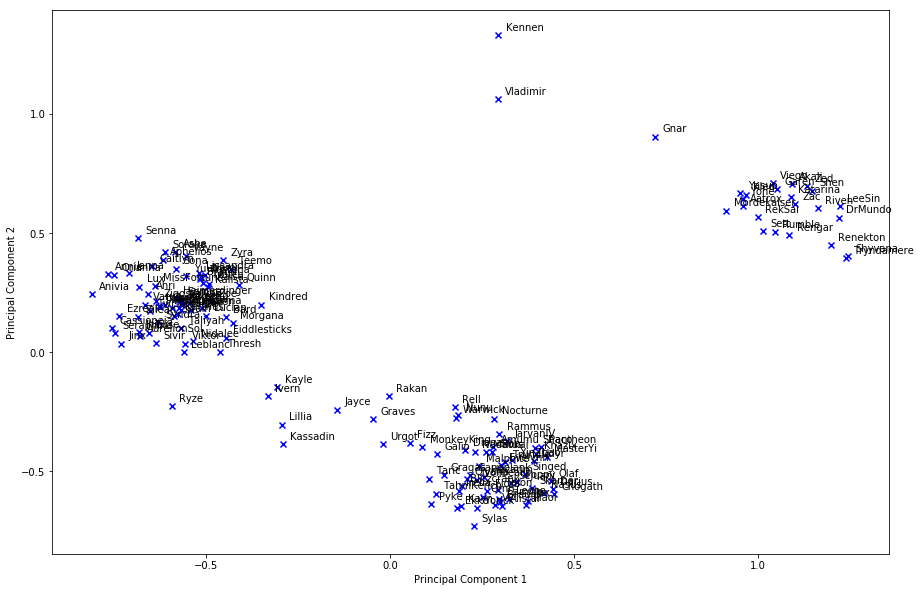

In [27]:
# plotting with minmax scaling
fig, ax = plt.subplots(figsize = (15, 10))

for i, key in enumerate(final_df['name']):
    # instantiates each x and y coordinate
    x_axis = principal_df['principal component 1'][i]
    y_axis = principal_df['principal component 2'][i]
    
    # creates scatterplot points
    ax.scatter(x_axis, y_axis, marker = 'x', color = 'b')
    
    # adds champion name to each point
    ax.text(x_axis + 0.02 , y_axis + 0.02, key, fontsize = 10)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show();

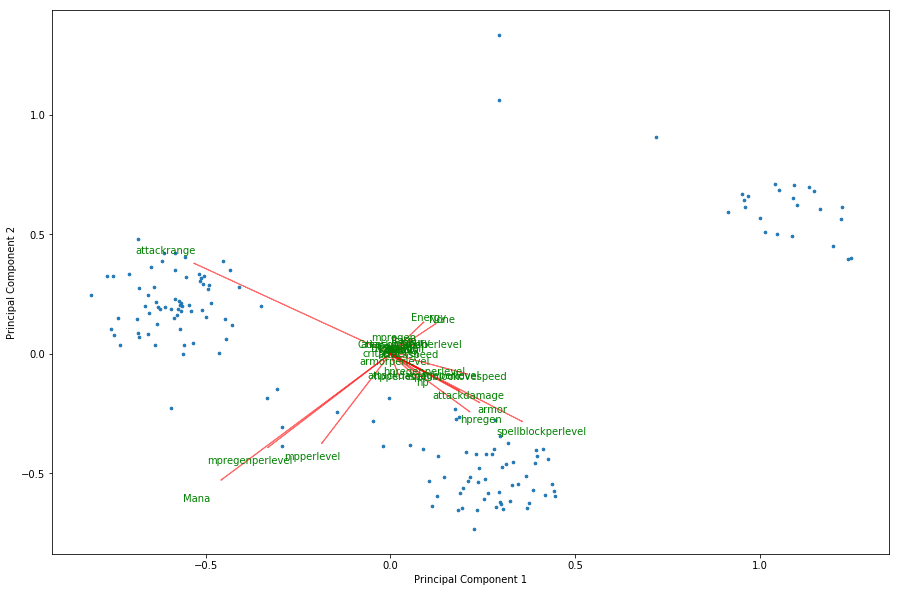

In [28]:
# byplot to figure out the relative magnitude of each feature on each component
fig, ax = plt.subplots(figsize = (15, 10))

# mapping out each feature with coeff
coeff = np.transpose(pca.components_[0:2, :])
x_axis = principal_components_minmax[:, 0]
y_axis = principal_components_minmax[:, 1]
n = coeff.shape[0]

# list of labels for different features
labels = list(x.columns)

# plotting points
ax.scatter(x_axis, y_axis, s = 7)

# labels each arrow with appropriate feature
for i in range(n):
    ax.arrow(0, 0, coeff[i, 0], coeff[i, 1],color = 'r', alpha = 0.5)
    ax.text(coeff[i, 0]* 1.15, coeff[i, 1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
    
plt.show();

It seems the three groups are at the top right, champions that don't use mana, at the bottom middle melee champions that use mana, and the left grouping being mana using ranged champions.

In [29]:
# logistic regression

In [30]:
x

,hp,hpperlevel,mp,mpperlevel,movespeed,armor,armorperlevel,spellblock,spellblockperlevel,attackrange,...,Energy,Ferocity,Flow,Fury,Grit,Heat,Mana,None,Rage,Shield
Orianna,530.0,91.0,418.00,25.0,325.0,17.0,3.00,26.0,0.50,525.0,...,0,0,0,0,0,0,1,0,0,0
Janna,500.0,70.0,350.00,64.0,315.0,28.0,3.80,30.0,0.50,550.0,...,0,0,0,0,0,0,1,0,0,0
Karthus,550.0,87.0,467.00,30.5,335.0,18.0,3.50,30.0,0.50,450.0,...,0,0,0,0,0,0,1,0,0,0
Lulu,525.0,74.0,350.00,55.0,330.0,29.0,3.70,30.0,0.50,550.0,...,0,0,0,0,0,0,1,0,0,0
Neeko,540.0,90.0,450.00,30.0,340.0,21.0,4.00,30.0,0.50,550.0,...,0,0,0,0,0,0,1,0,0,0
Kennen,541.0,84.0,200.00,0.0,335.0,29.0,3.75,30.0,0.50,550.0,...,1,0,0,0,0,0,0,0,0,0
Sona,480.0,77.0,340.00,45.0,325.0,28.0,3.30,30.0,0.50,550.0,...,0,0,0,0,0,0,1,0,0,0
Soraka,535.0,74.0,425.00,40.0,325.0,32.0,3.80,30.0,0.50,550.0,...,0,0,0,0,0,0,1,0,0,0
Senna,520.0,75.0,350.00,45.0,330.0,28.0,3.50,30.0,0.50,600.0,...,0,0,0,0,0,0,1,0,0,0
Ivern,585.0,85.0,450.00,60.0,330.0,27.0,3.50,32.0,1.25,475.0,...,0,0,0,0,0,0,1,0,0,0


In [103]:
# evaluate multinomial logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# # define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define the multinomial logistic regression model
model = LogisticRegression()
# fit the model on the whole dataset
X = x.values
y = champ_stats['Primary Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 5)
# model.fit(X, y)
model.fit(X_train, y_train)
preds = model.predict(X_test)

confusion_matrix(y_test, preds)

C:\Users\lm5571\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lm5571\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([[ 0,  2,  0,  0,  1,  0],
       [ 1,  8,  0,  0,  0,  3],
       [ 0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  8,  0,  0],
       [ 0,  1,  1,  0,  4,  0],
       [ 3,  3,  0,  0,  1,  0]], dtype=int64)

In [104]:
confmtrx = np.array(confusion_matrix(y_test, preds))
class_array = np.sort(y.unique())
pd.DataFrame(confmtrx, index=class_array,
columns='predicted ' + class_array)

,predicted Assassin,predicted Fighter,predicted Mage,predicted Marksman,predicted Support,predicted Tank
Assassin,0,2,0,0,1,0
Fighter,1,8,0,0,0,3
Mage,0,0,11,0,0,0
Marksman,0,0,0,8,0,0
Support,0,1,1,0,4,0
Tank,3,3,0,0,1,0


In [105]:
print('Accuracy Score:', accuracy_score(y_test, preds))  

#Create classification report
class_report=classification_report(y_test, preds)
print(class_report)

Accuracy Score: 0.6595744680851063
              precision    recall  f1-score   support

    Assassin       0.00      0.00      0.00         3
     Fighter       0.57      0.67      0.62        12
        Mage       0.92      1.00      0.96        11
    Marksman       1.00      1.00      1.00         8
     Support       0.67      0.67      0.67         6
        Tank       0.00      0.00      0.00         7

    accuracy                           0.66        47
   macro avg       0.53      0.56      0.54        47
weighted avg       0.62      0.66      0.64        47



In [106]:
coef_df = pd.DataFrame(model.coef_, np.sort(y.unique()), columns=x.columns)
# with low accurcythere is not point tyring intepret the logistic regression. Instead let's turn to a clustering algorithm

In [ ]:
# clustering